In [81]:
import numpy as np
from qutip import wigner, fock, Qobj, displace, destroy, tensor, qeye, coherent
from scipy.special import genlaguerre
from math import sqrt, factorial
import qutip
import matplotlib.pyplot as plt
from scipy.linalg import lstsq, eigh, svd  
from scipy.sparse.linalg import LinearOperator, lsqr
import h5py
from qutip import*
from tcsim.visualization import*
from tcsim.gates import*
import matplotlib.pyplot as plt

def make_disps(xmax, N):
    xs = np.linspace(-xmax, xmax, N)
    X, Y = np.meshgrid(xs, xs)
    return (X + 1j*Y).flatten()
# flatten means a matrix can be transformed to a list with the order of row.

def vectorize(rho):
    """
    Turn hermitian matrix rho into a real vector
    vectorize(rho)[:d] = diag(rho)
    vectorize(rho)[d:d + d*(d-1)/2] = Re[upper_triangle(rho)]
    vectorize(rho)[d + d*(d-1)/2:]  = Im[upper_triangle(rho)]
    """
    d = rho.shape[0]  ## the shape of first column - dimension of matrix, e.g. 3x3 matrix d = 3
    n_offd = d*(d-1)//2 
    ret = np.zeros(d**2) #array of zeros with dimensionality d**2
    i = 0
    for m in range(d):
        ret[m] = rho[m, m].real #mth entry in ret is real part of (m,m) diagonal entry of matrix, capped at d
        for n in range(m+1, d):
            ret[d+i] = rho[m, n].real  #set d+ith entry in ret to real part of (m,n) off diagonal entry of matrix
            ret[d+n_offd+i] = rho[m, n].imag
            i += 1
    return ret


def matricize(rvec):
    """
    Invert the vectorize operation such that matricize(vectorize(rho)) == rho
    """
    d = int(np.sqrt(len(rvec)))
    n_offd = d*(d-1)//2
    ret = np.diag(rvec[:d]).astype(np.complex) # 将rvec[:d]转化为一个对角矩阵，并且用a+jb的形式表示
    i = 0
    for m in range(d):
        for n in range(m+1, d):
            real = rvec[d+i]
            imag = rvec[d+n_offd+i]
            val = real + 1j*imag
            ret[m, n] = val
            ret[n, m] = val.conj()
            i += 1
    return ret


def complex_char_mat(disps, d):
    n_disp = len(disps)
    n_offd = (d*(d-1))//2
    dm = np.zeros((n_disp, d*d), dtype=np.complex)
    alpha = disps
    i = 0
    B = abs(alpha)**2
    for n in range(d):
        dm[:, n] = genlaguerre(n, 0)(B)
        for m in range(n+1, d):
            off_d = np.sqrt(factorial(n)/factorial(m)) * genlaguerre(n, m-n)(B)
            dm[:, d+i] = (off_d * (alpha**(m-n) + (-alpha.conjugate())**(m-n)))
            dm[:, d + n_offd + i] = (1j * off_d * (alpha**(m-n) - (-alpha.conjugate())**(m-n)))
            i += 1
    dm = np.einsum('ij,i->ij', dm, np.exp(-B / 2))
    return dm

def reconstruct_char_complex(char, disps, dim):
    M = complex_char_mat(disps, dim)
    rv = lsqr(M, char, damp = 2)[0]
    rho = matricize(rv)
    return rho


def reconstruct_char_from_data(data, x_data, y_data, dim, scale, plot=True):
  
    # turn x_data and y_data into an appropriate grid and flatten to hand it to reconstruct_char_complex as disps
    X, Y = np.meshgrid(x_data, y_data)
    
    disps = (1j*X + Y).flatten()
    
    #data = (data/np.min(data))
    
    # correct offset and scale data
    #data_scale_offset = (data - np.mean(data[0]))/np.max(data)
    rho = Qobj(reconstruct_char_complex(data.flatten(), disps*scale, dim))
    
    if plot:
        fig, ax = plt.subplots(1,3, figsize = (10,10) )
        ax[0].set_aspect('equal')
        ax[1].set_aspect('equal')
        ax[2].set_aspect('equal')
        ax[0].pcolormesh(x_data, y_data, data, cmap = 'bwr', vmin=-1, vmax = 1) 
        
        plot_char(qt.tensor(qt.fock(2,0).dag()*qt.fock(2,0),rho.unit()), ax=ax[1], max_alpha = scale, vmin = -1, vmax = 1)
        plot_char(qt.tensor(qt.fock(2,0).dag()*qt.fock(2,0),rho.unit()), ax=ax[2], real=False, max_alpha = scale,  vmin = -1, vmax = 1)
        ax[0].set_title("Experimental Data")
        ax[1].set_title("Recon char real")
        ax[2].set_title("Recon char im")
        
    return rho.unit()
    
    

## 1. Try theoretical data without noise
-> easily achieve oerlap 1

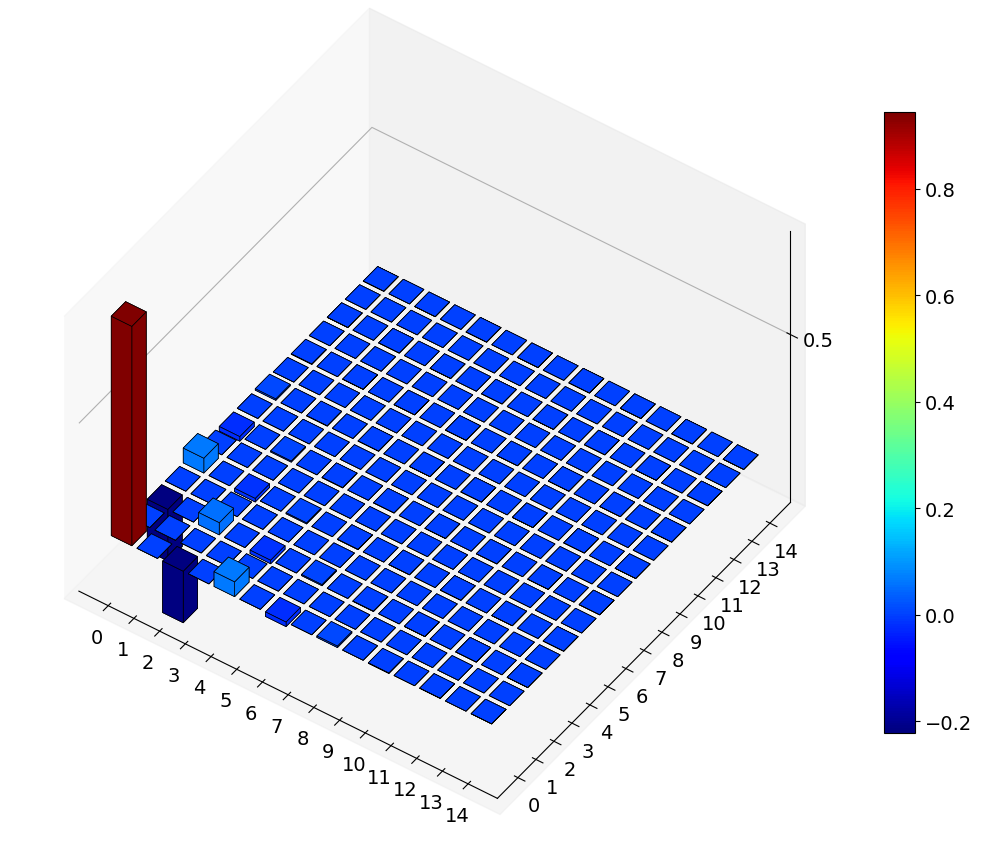

In [100]:
## plot the dm of the theoretical state to determine the necessary photon number in reconstruction HOWEVER, this state is then put into a grid. therefore, we have to check that we still have everything if we add a displacement to it.
N = 15
psi_ideal = squeeze(N, calc_squeez_parameter(3))*fock(N,0)
rho_ideal = ket2dm(psi_ideal)
fig, ax = qt.matrix_histogram(rho_ideal)
ax.view_init(azim=-55, elev=45)

plt.show()

C:\Users\jonat\AppData\Local\Temp\ipykernel_21196\2988245724.py:63: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dm = np.zeros((n_disp, d*d), dtype=np.complex)
C:\Users\jonat\AppData\Local\Temp\ipykernel_21196\2988245724.py:47: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ret = np.diag(rvec[:d]).astype(np.complex) # 将r

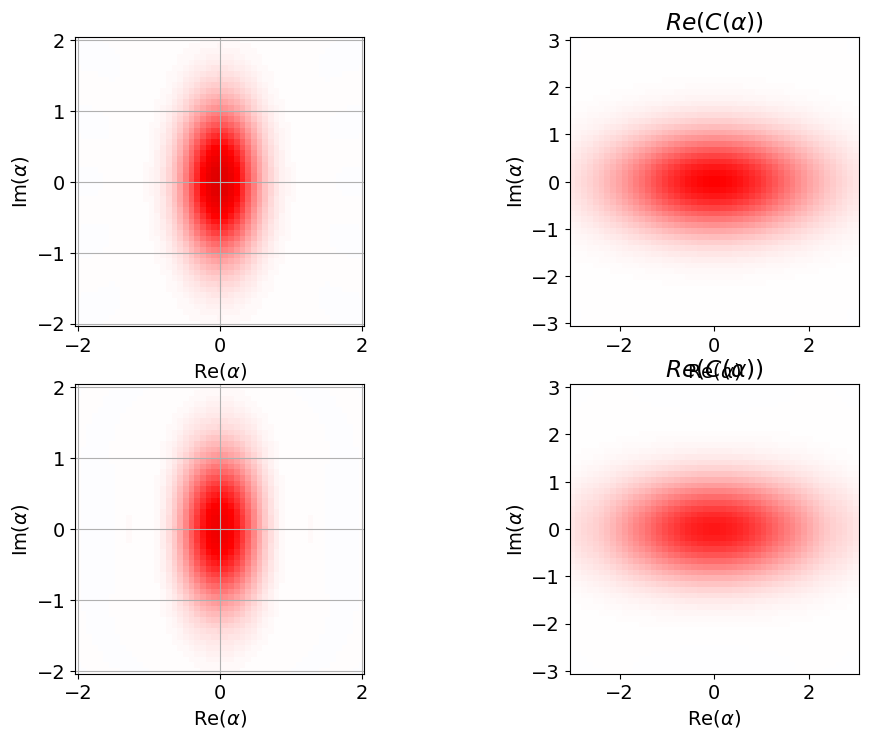

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

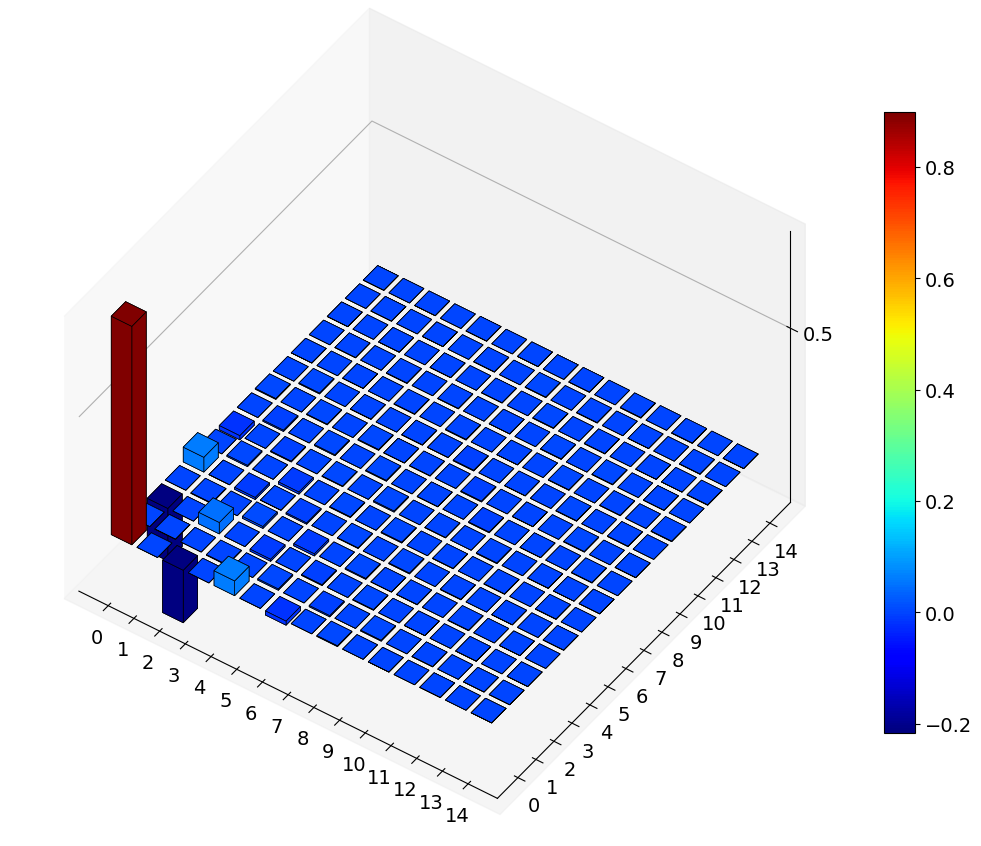

In [101]:
N_reconstruct = 15

xvec = np.linspace(-3,3,31)
char_real, char_im = char_func_grid(tensor(fock(2,0),psi_ideal),xvec)

char_func_flat = (char_real+1j*char_im).T.flatten()
#char_func_flat  = char_real.flatten()*2

rho = Qobj(reconstruct_char_complex(char_func_flat,make_disps(3,31), N_reconstruct)) 

rho_tensor = tensor(qt.fock(2,0)*qt.fock(2,0).dag(),rho)

fig, ax = plt.subplots(2,2)
plot_wigner(tensor(fock(2,0),psi), ax = ax[0][0])
plot_char(tensor(fock(2,0),psi), ax = ax[0][1]) 

plot_wigner(rho_tensor.unit(), ax = ax[1][0])
plot_char(rho_tensor.unit(), ax = ax[1][1]) 
fig, ax = qt.matrix_histogram(rho)
ax.view_init(azim=-55, elev=45)
print(rho.overlap(rho_ideal))


## 2. Try experimental data

In [70]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import os

files1 = []
files2 = []
files = []

d = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/"
files = [f for f in os.listdir(d) if f.endswith('panther_ECD_char_pre_postselect_2uv_real.h5')]

files

['101129_panther_ECD_char_pre_postselect_2uv_real.h5',
 '102126_panther_ECD_char_pre_postselect_2uv_real.h5',
 '103123_panther_ECD_char_pre_postselect_2uv_real.h5',
 '104119_panther_ECD_char_pre_postselect_2uv_real.h5',
 '105116_panther_ECD_char_pre_postselect_2uv_real.h5',
 '110113_panther_ECD_char_pre_postselect_2uv_real.h5',
 '111109_panther_ECD_char_pre_postselect_2uv_real.h5',
 '112106_panther_ECD_char_pre_postselect_2uv_real.h5',
 '113103_panther_ECD_char_pre_postselect_2uv_real.h5',
 '114100_panther_ECD_char_pre_postselect_2uv_real.h5',
 '115056_panther_ECD_char_pre_postselect_2uv_real.h5',
 '120053_panther_ECD_char_pre_postselect_2uv_real.h5',
 '121050_panther_ECD_char_pre_postselect_2uv_real.h5',
 '122046_panther_ECD_char_pre_postselect_2uv_real.h5',
 '123043_panther_ECD_char_pre_postselect_2uv_real.h5',
 '124040_panther_ECD_char_pre_postselect_2uv_real.h5',
 '125036_panther_ECD_char_pre_postselect_2uv_real.h5',
 '130033_panther_ECD_char_pre_postselect_2uv_real.h5',
 '131030_p

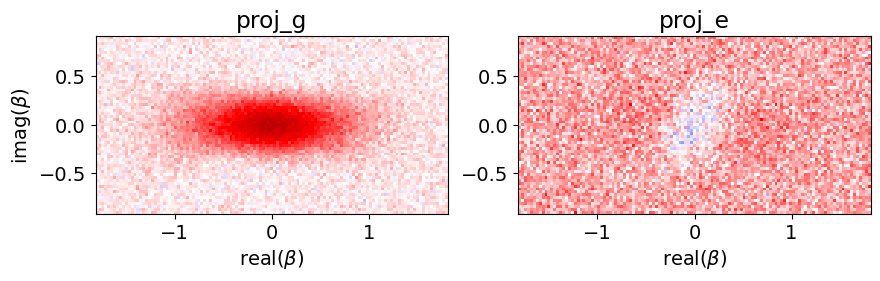

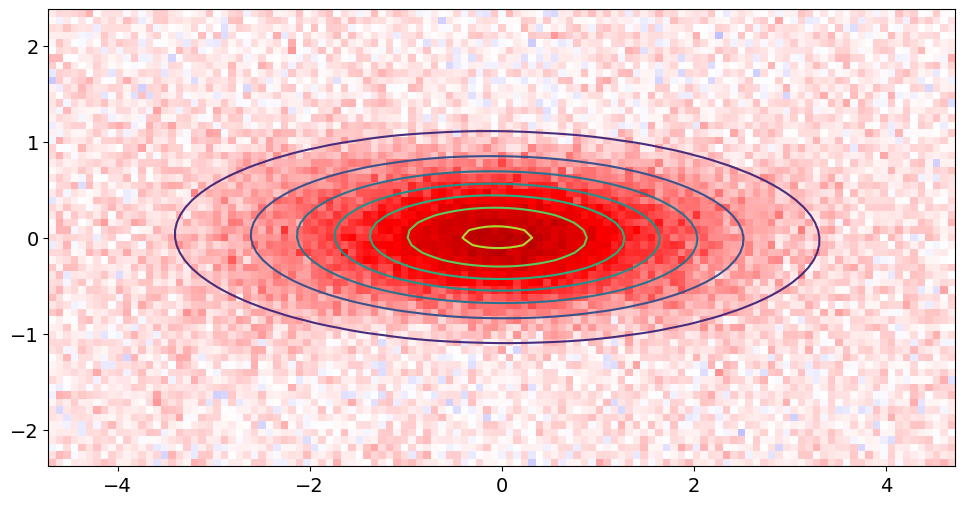

In [71]:
dg = []
de = []

#files = files[-5:-1]

for kk in range(len(files)):
    fname = d + files[kk]
    df = h5py.File(fname, "r")
    data = df["data"]
    data_i = data["I"][:]
    x = data["x"][:, 0][:, 0]
    y = data["y"][0, :][:, 0]
    n_points_x = len(x)  # sweep points x
    n_points_y = len(y)  # sweep points y
    thresh = +0.00022 #-3.112326057411744e-05
    ss_data = np.where(data_i < thresh, 1, 0)
    m0 = ss_data[:, 0::3]
    m1 = ss_data[:, 1::3] 
    m2 = ss_data[:, 2::3]
    m1_g = ma.masked_array(m1, mask=m0)
    m2_g = ma.masked_array(m2, mask=m0)

    ## only care about last two measurements
    proj_g = ma.masked_array(m2, mask=m1).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1
    proj_e = ma.masked_array(m2, mask=np.logical_not(m1)).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1

    ## condition on the first measurement as well
    double_ps_g = ma.masked_array(m2_g, mask=m1_g).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1
    double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g)).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1

    dg.append(double_ps_g)
    de.append(double_ps_e)

    
dg = np.array(dg)
de = np.array(de)


proj_g = dg.mean(axis=0)
proj_e = de.mean(axis=0)
proj_ge = [proj_g, proj_e]  # m2.mean(axis = 0).reshape(n_points, n_points)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
f1 = ax1.pcolormesh(y, x, proj_g, cmap="seismic", vmax=1, vmin=-1)
f2 = ax2.pcolormesh(y, x, proj_e, cmap="seismic", vmax=1, vmin=-1)
ax1.set_aspect("equal")
ax1.set_xlabel(r"real($\beta$)")
ax1.set_ylabel(r"imag($\beta$)")
ax1.set_title('proj_g')
ax2.set_aspect("equal")
ax2.set_xlabel(r"real($\beta$)")
ax2.set_title('proj_e')
# fig.colorbar(f2)
########################  2D plot ##################
import h5py
import matplotlib.pyplot as plt
import numpy as np
from qutip import*
import scipy.optimize as opt
# Everything in plae to be able to manipulate it quickly here if  needed.


N = 40
## cavity operators
a = tensor(destroy(N), qeye(2))
## qubit operator 
def char_func_grid(state, xvec):
    """Calculate the Characteristic function as a 2Dgrid (xvec, xvec) for a given state.

    Args:
        state (Qobject): State of which we want to calc the charfunc
        xvec (_type_): array of displacements. The char func will be calculated for the grid (xvec, xvec)

    Returns:
        tuple(ndarray, ndarray): Re(char func), Im(char func)
    """
    cfReal = np.empty((len(xvec),len(xvec)))
    cfImag = np.empty((len(xvec),len(xvec)))

    for i, alpha_x in enumerate(xvec):
        for j, alpha_p in enumerate(xvec):
            expect_value = expect(displace(N, alpha_x +1j*alpha_p),state)
            cfReal[i,j] =  np.real(expect_value)
            cfImag[i,j] =  np.imag(expect_value)

    return cfReal,cfImag  

def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

def twoD_Gaussian(xy_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x,y) = xy_tuple
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

""" 
Use the above plot to make good intial guesses!

"""
scaling = 2.6
# add some noise to the data and try to fit the data generated beforehand
initial_guess = (0.5, 0, 0, 0.1, 0.6, -np.pi/2, 0) # upper blob


xvec = x*scaling # i define it like this in case i want to slice x
yvec = y*scaling
X, Y = np.meshgrid(yvec, xvec)

data = proj_g

popt1, pcov1 = opt.curve_fit(twoD_Gaussian, (X, Y), data.flatten(), p0=initial_guess)



data_fitted1 = twoD_Gaussian((X, Y), *popt1)

fig, ax = plt.subplots(1, 1)

ax.pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
ax.contour(yvec,xvec, data_fitted1.reshape(len(x),len(y)))
ax.set_aspect("equal")
plt.show()

In [72]:
def find_background(data):
    def portion_sea(thresh):
        return np.sum(data>thresh)
    half=np.size(data)/2
    up,down=1.,-1.
    for i in range(100):
        val=(up+down)/2
        if portion_sea(val)>half:
            down=val
        else:
            up=val
    return up

In [73]:
find_background(proj_g)

0.07301455854087434

6


C:\Users\jonat\AppData\Local\Temp\ipykernel_21196\2988245724.py:63: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dm = np.zeros((n_disp, d*d), dtype=np.complex)
C:\Users\jonat\AppData\Local\Temp\ipykernel_21196\2988245724.py:47: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ret = np.diag(rvec[:d]).astype(np.complex) # 将r

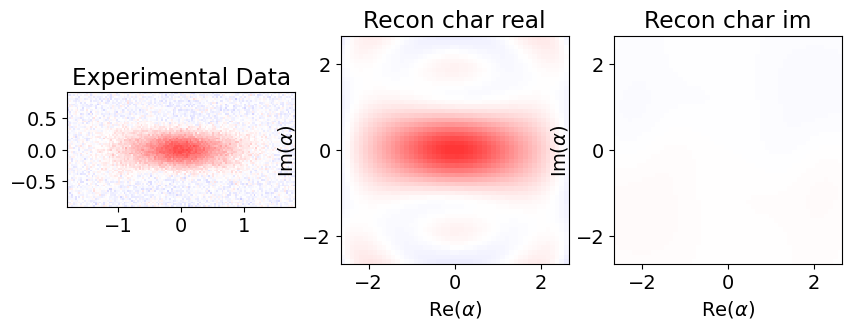

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

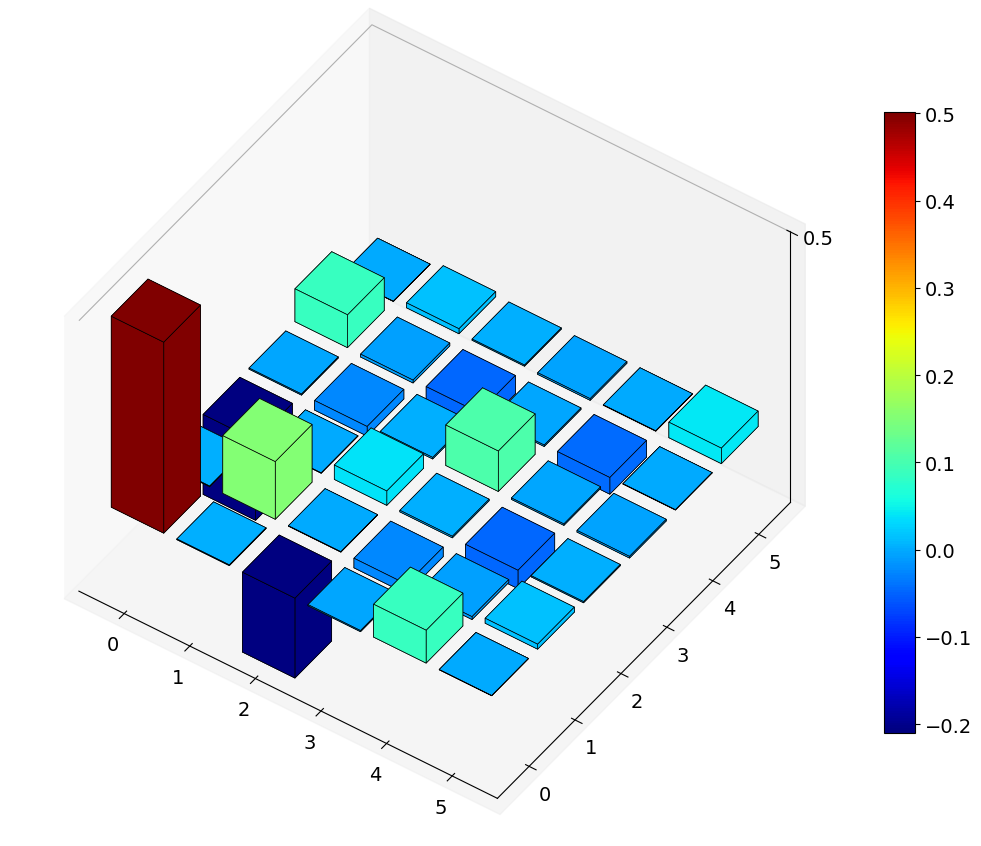

squeezing in db
2.1539528953726608
-4.451205916186131
7


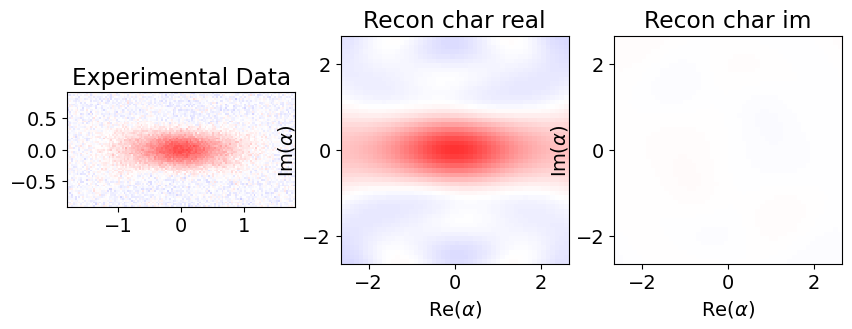

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

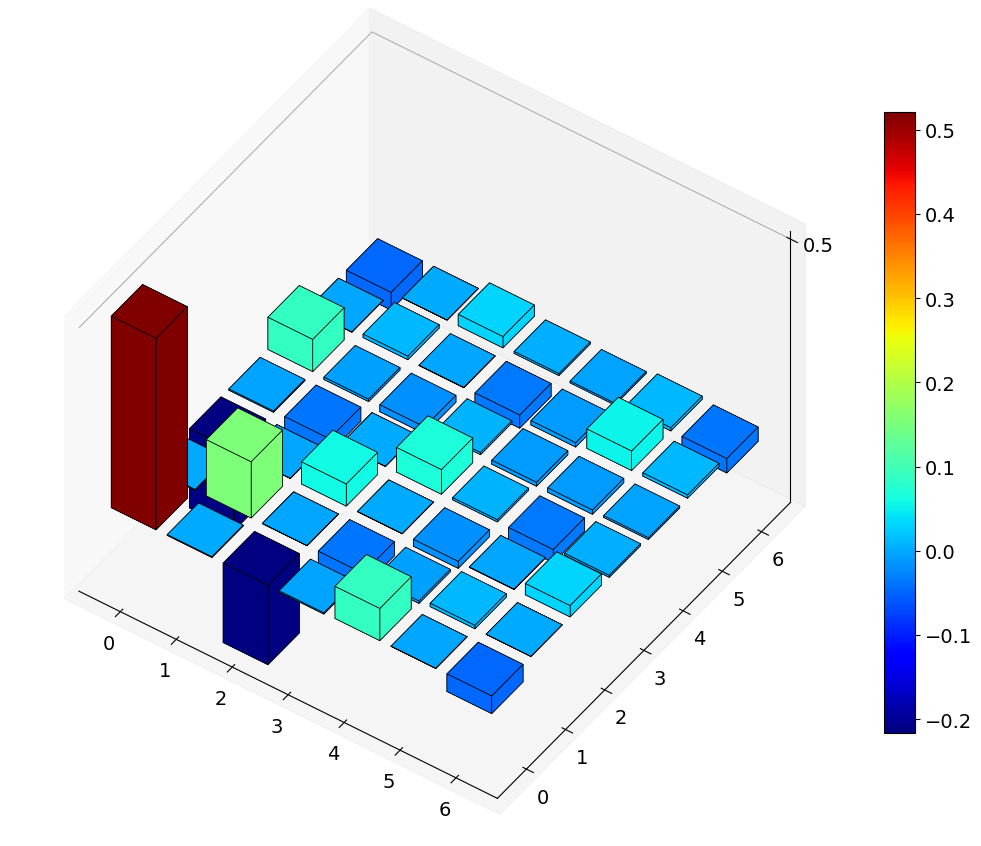

squeezing in db
1.5573480837935683
-5.179789881578847
8


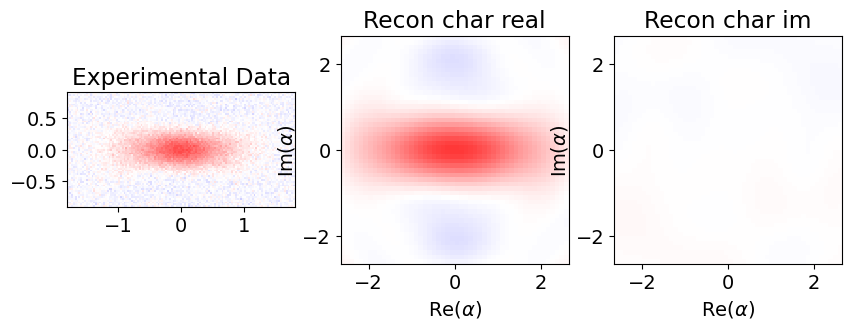

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

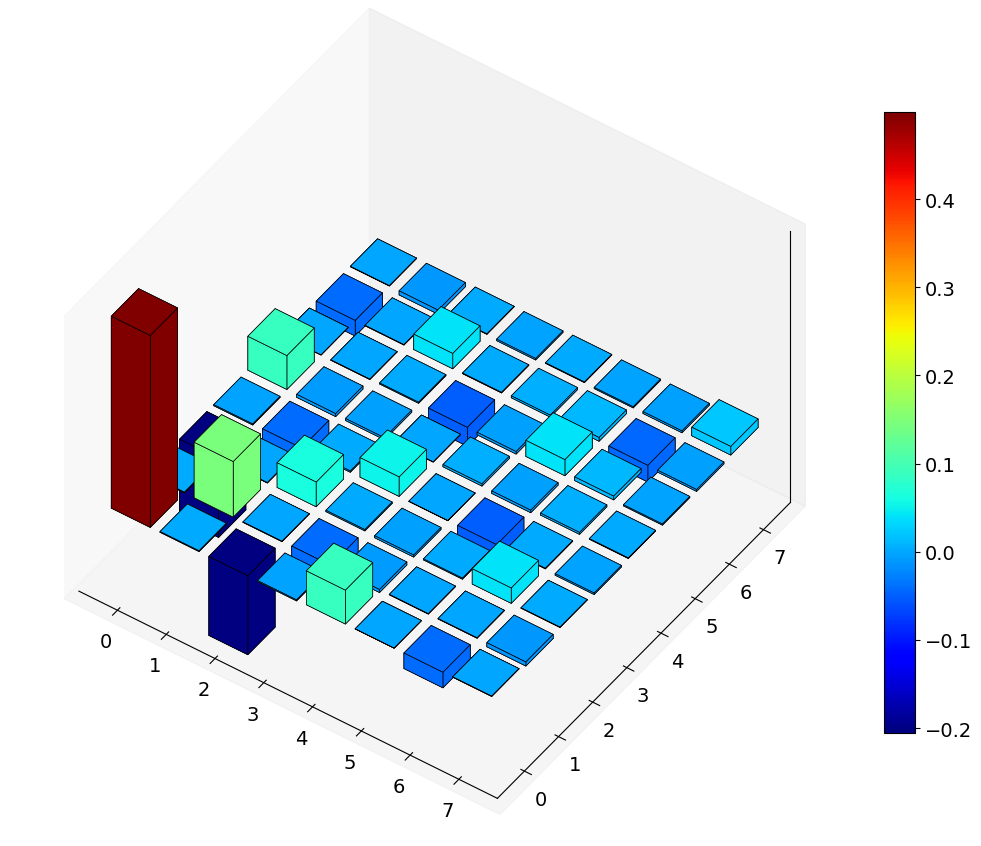

squeezing in db
3.346557591936557
-4.707604028134499


In [75]:
def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

for N in range(6,9):
    print(N)

    Iq = qeye(2)
    Ic = qeye(N)
    a = destroy(N)
    sx = sigmax()
    sz = sigmaz()

    # if the fitted char func has an angle, i have to adjust my quadrature operators to calculate the squeezing along the correct axis
    angle = popt1[5]+np.pi/2
    X_phi = (a*np.exp(-1j*angle) + a.dag()*np.exp(1j*angle))/2
    P_phi = (a*np.exp(-1j*(angle+np.pi/2)) + a.dag()*np.exp(1j*(angle+np.pi/2)))/2
    Q = (a + a.dag())/2
    P = -1j*(a-a.dag())/2


    rho = reconstruct_char_from_data(proj_g-find_background(proj_g), y, x, N, scale=2.6)
    fig, ax = qt.matrix_histogram(rho)
    ax.view_init(azim=-55, elev=45)

    plt.show()
    # print("N = ", N)
    # print("variances")
    # print(qt.expect(X_phi**2,rho))
    # print(qt.expect(P_phi**2,rho))
    print("squeezing in db")
    dbx = -10*np.log10(qt.expect(X_phi**2,rho)*4)
    dbp = -10*np.log10(qt.expect(P_phi**2,rho)*4)
    print(dbx)
    print(dbp)



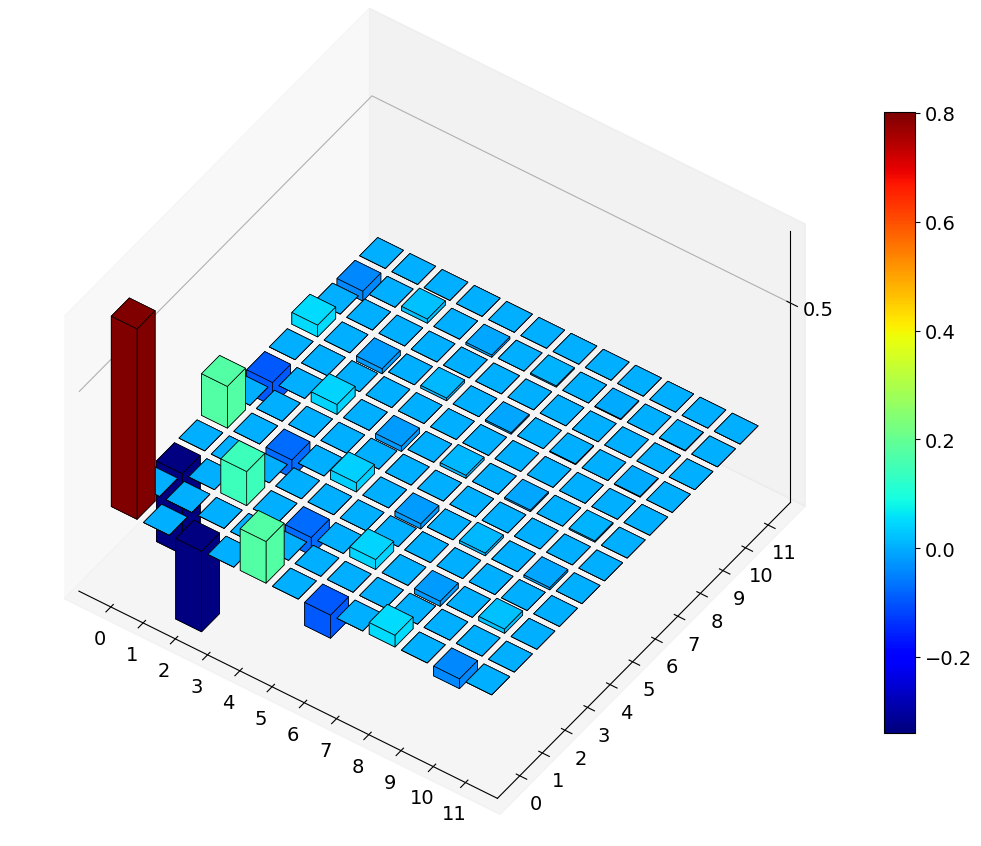

In [52]:
## plot the dm of the theoretical state to determine the necessary photon number in reconstruction
N = 12
psi = squeeze(N, calc_squeez_parameter(6))*fock(N,0)
fig, ax = qt.matrix_histogram(ket2dm(psi))
ax.view_init(azim=-55, elev=45)

plt.show()

Bisheriges Fazit: 
ohne damping bekomme ich probleme für  n>9
immer noch fast unmoglich zu sagen welche dimension am besten ist, da die resultierenden squeezing werte stark abweichen.